# Visual Robot Collision Identification

We are deploying a Kuka robot in a factory, and we want to implement a remote visual monitoring system. Part of this system includes automatic identification of collisions. We will train a machine learning model on image data to build this system. We've provided some code from previous assignments to facilitate this task.

**You should download this notebook and complete it on Colab or another platform that can access GPU hardware. For submission, please attach the notebook printout to your PDF submission on Gradescope, and also re-upload the completed notebook with outputs here.**

In [3]:
!pip install pybullet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 9.2 MB/s eta 0:00:00


In [4]:
import os
import time
import pybullet as p
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.image as mpl_img
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

In [5]:
# Set up the simulation
sim_id = p.connect(p.DIRECT)

In [6]:
# PyBullet has a lot of built-in data (e.g., robor models), so let's get access to it
import pybullet_data
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [7]:
# load up the robots!
p.resetSimulation()
plane_id=p.loadURDF('plane.urdf',
            physicsClientId=sim_id)
robot_id=p.loadURDF("kuka_iiwa/model.urdf",
            basePosition=[0,0,0],
            baseOrientation=p.getQuaternionFromEuler([0,0,0]),
            useFixedBase=True,
            physicsClientId=sim_id,
            globalScaling=1,
            flags=p.URDF_USE_IMPLICIT_CYLINDER)
cube_id=p.loadURDF('cube.urdf',
            basePosition=[0.5, 0, 0.5],
            physicsClientId=sim_id,
            globalScaling=0.3)
sphere_id=p.loadURDF('sphere2.urdf',
            basePosition=[0, 0.5, 0.5],
            physicsClientId=sim_id,
            globalScaling=0.3)
p.getNumBodies()

4

In [8]:
def is_collision():
    p.performCollisionDetection(physicsClientId=sim_id)
    all_contact_points = [cp for cp in p.getContactPoints(bodyA=robot_id) \
                          if cp[1] != plane_id and cp[2] != plane_id and cp[8] < 0]
    # cp[1] is first collision object, cp[2] is second collision object
    # cp[8] is collision distance, where NEGATIVE value indicates penetration (pos value is separation)
    return len(all_contact_points) > 0

In [9]:
JOINT_LIMITS = np.array([np.pi * 3/4, np.pi * 2/3, np.pi * 3/4, np.pi * 2/3, np.pi * 3/4, np.pi * 2/3, np.pi * 3/4])

# Part 1: Model Selection (4 pts)

We will be using a pre-trained ResNet-18 model, which is a type of convolutional neural network. Briefly answer the following:
* Why is a convolutional neural network a good choice for this task?
* Why is a pre-trained model a good choice for this task?


CNNs are well suited for visual tasks which, in our case, is identifying images where a collision between the robot and an object occurs. The convolutional layers of the network will "learn" to recognize visual features in each image that indicate a collision.

Using a pretrained model is a good choice because it has already been trained on hundreds of thousands of images and thus, can generalize its knowledge for our task. We have a relatively small set of training images, so if we didn't use a pretrained model, the accuracy would be very low as the network would be unable to recognize more nuanced features.

# Part 2: Data Collection (8 pts)

We will generate training data by collecting 1000 images of robots in various collision statuses. We can do so by repeating the following steps:
* Sample a random configuration within joint limits.
* Find its collision status using `is_collision()`.
* Generate and store the rgb image using `show_image()` (needs to be amended).

The images should be saved in a folder called ``robot_imgs``, with file name formats ``pose{sample_number}_{collision_status}.png``, where ``collision_status`` is 1 for collision, 0 for no collision. See below for proposed directory format.

```
robot_imgs/
  pose0_1.png
  pose1_1.png
  pose2_1.png
  pose3_0.png
  pose4_0.png
  pose5_1.png
  pose6_0.png
```



In [10]:
# run this if you need to regenerate the images
import shutil
if os.path.exists('robot_imgs'):
    shutil.rmtree('robot_imgs')
os.makedirs('robot_imgs', exist_ok=True)

In [11]:
def showImage(img_idx, collision_status, cameraPos=[2, 2, 2]):
    # Let's take some images, as a sanity check:
    viewMatrix = p.computeViewMatrix(
                cameraEyePosition=cameraPos,
                cameraTargetPosition=[0, 0, 0],
                cameraUpVector=[0, 0, 1])
    projectionMatrix = p.computeProjectionMatrixFOV(
                fov=60.0,
                aspect=1.0,
                nearVal=0.1,
                farVal=10)
    width, height, rgbImg, depthImg, segImg = p.getCameraImage(
                width=512,
                height=512,
                viewMatrix=viewMatrix,
                projectionMatrix=projectionMatrix)

    # TODO: Save the image in folder structure as shown above.
    # HINT: use matplotlib.image (already imported as mpl_img)
    mpl_img.imsave(f'robot_imgs/pose{img_idx}_{collision_status}.jpg', rgbImg)


In [12]:
# TODO: Sample and save 1000 images of robot configurations and their collision status
for i in range(1000):
  collision_status = 0
  joint_angles = np.random.uniform(-JOINT_LIMITS, JOINT_LIMITS, size=JOINT_LIMITS.shape)
  for joint_index, angle in enumerate(joint_angles):
        p.resetJointState(robot_id, joint_index, angle)

  if is_collision(): collision_status = 1
  showImage(i, collision_status)

# Part 3: Dataset Class (10 pts)

We will be using PyTorch to train a model. We need to have a ``Dataset`` subclass, which gives data to PyTorch in the form of tuples ``(image, label)``. We also want an option to split the images into train and test sets, which we can do by specifying `desired_indices` as the training images. Feel free to read this tutorial (from which much of the code in this assignment was adopted) for help: [PyTorch DataLoading](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

Complete the main loop in the ``load_all_images()`` function in the ``RobotCollisionDataset`` class below by performing the following:

* Retrieve each image with index in `desired_indices`.
* Convert the image to a tensor and ensure that its dimensions are `(3,512,512)`. [`torch.from_numpy()`](https://pytorch.org/docs/stable/generated/torch.from_numpy.html) and [`torch.permute()`](https://pytorch.org/docs/stable/generated/torch.permute.html) may be useful here.
* Append the tensor to the `images` list and the corresponding collision status (1/0) to the `labels` list.

In [13]:
import re
class RobotCollisionDataset(Dataset):
    """Face Landmarks dataset."""
    def __init__(self, root_dir, desired_indices):
        """
        Arguments:
            root_dir (string): Directory with all the images.
        """
        self.root_dir = root_dir
        self.desired_indices = desired_indices
        self.images, self.labels = self.load_all_images()

        self.transform = transforms.Compose([
            transforms.Normalize((201, 212, 230), (42, 33, 23)),
            transforms.Resize((224, 224))
        ])

    def load_all_images(self):
        """
        Creates:
        -> self.images: contains robot images from self.root_dir
        -> self.labels: self.labels[i] = 1 if self.images[i] depicts a collision, 0 otherwise
        """
        images = list()
        labels = list()
        assert os.path.exists(self.root_dir)

        for filename in os.listdir(self.root_dir):
          idx_match = re.search(r'pose(\d+)_', filename)
          img_idx = int(idx_match.group(1))
          if img_idx >= self.desired_indices[0] and img_idx < self.desired_indices[1]:
            img_data = self.load_image(f'{self.root_dir}/{filename}')
            label_match = re.search(r'_(\d+).jpg', filename)
            label = int(label_match.group(1))
            img_tensor = torch.from_numpy(img_data)
            img_tensor = img_tensor.permute(2, 1, 0)
            images.append(img_tensor)
            labels.append(label)

        assert len(labels) == len(images)
        return images, labels

    # Thanks https://stackoverflow.com/a/7769424
    def load_image(self, infilename) :
        img = Image.open(infilename)
        img.load()
        data = np.asarray(img, dtype="float32")
        return data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx = idx.tolist()
        return self.transform(self.images[idx]), self.labels[idx]

# Part 4: Loading the Data and Model (6 pts)

Now we can create our dataset and store it in two `RobotCollisionDataset` objects. First define `train_dataset` containing 900 images, and `val_dataset` containing the remaining 100 images. This should only require a couple lines of code.

Next, we will load a pre-trained ResNet model. To use it for our collision detection task, we need to ensure that the model has the correct output layer dimensionality. Recall that the output layer for a neural network is the probability distribution over categories. Natively, ResNet has 1000 dimensions in the output layer because it was trained for a 1000-category classification task.

Load the `resnet18` model with default weights into a variable called `model` and change its dimensionality as necessary. This should only require a couple lines of code. This tutorial may be helpful: [Transfer Learning for Computer Vision](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [14]:
# TODO: Create train and validation datasets
root_directory = 'robot_imgs'
train_dataset = RobotCollisionDataset(root_directory, (0, 900))
val_dataset = RobotCollisionDataset(root_directory, (900, 1000))

In [15]:
# TODO: Load and adjust a pre-trained model
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


# Part 5: Training the Model (4 pts)

The last function we need to write is one that will train and validate the model. We have a partial implementation of `train_model()` below. Complete the loop portion that performs prediction and obtains a loss on an input. Additionally, if the current `phase` is `'train'`, you will need to perform an optimization step on the model (this second step would not be done if `phase` is `'val'`).

Note that this function essentially replicates the example shown in the [Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) tutorial. You are free to replicate any code from there to complete the implementation.

In [16]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25, device='cuda'):
    since = time.time()
    best_model_params_path = 'best_model_params.pt'
    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    train_losses = list()
    train_accs = list()
    val_losses = list()
    val_accs = list()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # TODO: Obtain model prediction and loss on inputs
                # If in training phase, compute gradients and perform optimization step
                with torch.set_grad_enabled(phase == 'train'):
                  outputs = model(inputs)
                  _, preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                  if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    return model, train_losses, train_accs, val_losses, val_accs

# Part 6: Putting Everything Together (8 pts)

Now we are ready to put everything together. The following code sets up the required components (model, criterion, optimizer, scheduler) and then runs the training function that you completed above. There are also some parameters, e.g. learning rate and number of epochs, that you can experiment with after verifying initial success.

**NOTE: Set your runtime hardware to ``T4 GPU`` only when you are ready to train the full model. Do not do so before that, or you will risk using up your GPU quota. It takes almost two hours to train on CPU, but only about five minutes on GPU.**

Run the provided code, and address the prompts below.

1. Use ``plot_losses()`` to plot the training and validation losses. Describe your observations and how they indicate that our learning task is successful (or failed).

2. Use ``visualize_model()`` to see some images along with their predictions. Do the predictions appear mostly correct? Do you see any failure cases?

3. Experiment with changing the learning rate and number of epochs. You can just try a lower and a higher value for each parameter separately. Comment on changes in model performance.

4. Experiment with loading a ResNet model that isn't pre-trained. Comment on changes in model performance.

In [17]:
learning_rate = 0.001
num_epochs = 25

data_loader_train = DataLoader(train_dataset,
                            batch_size=64, shuffle=True)
data_loader_val = DataLoader(val_dataset,
                            batch_size=64, shuffle=True)
dataloaders = {'train': data_loader_train,
               'val': data_loader_val}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/24
----------


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


train Loss: 0.5612 Acc: 0.7156


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


val Loss: 0.3267 Acc: 0.8400

Epoch 1/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.3646 Acc: 0.8156


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


val Loss: 0.2697 Acc: 0.8500

Epoch 2/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.3398 Acc: 0.8533


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


val Loss: 0.3460 Acc: 0.8200

Epoch 3/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.2519 Acc: 0.8944


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


val Loss: 0.2720 Acc: 0.8800

Epoch 4/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.1958 Acc: 0.9211


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


val Loss: 0.2962 Acc: 0.8500

Epoch 5/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train Loss: 0.1465 Acc: 0.9544


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val Loss: 0.2913 Acc: 0.8900

Epoch 6/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


train Loss: 0.1150 Acc: 0.9611


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


val Loss: 0.3015 Acc: 0.8400

Epoch 7/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


train Loss: 0.0975 Acc: 0.9789


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


val Loss: 0.2566 Acc: 0.8700

Epoch 8/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


train Loss: 0.0842 Acc: 0.9800


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


val Loss: 0.2376 Acc: 0.8700

Epoch 9/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


train Loss: 0.0799 Acc: 0.9878


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


val Loss: 0.2365 Acc: 0.8700

Epoch 10/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


train Loss: 0.0690 Acc: 0.9900


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


val Loss: 0.2548 Acc: 0.8600

Epoch 11/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


train Loss: 0.0667 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


val Loss: 0.2413 Acc: 0.8700

Epoch 12/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


train Loss: 0.0662 Acc: 0.9844


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2341 Acc: 0.8700

Epoch 13/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


train Loss: 0.0628 Acc: 0.9911


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.2522 Acc: 0.8500

Epoch 14/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


train Loss: 0.0596 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


val Loss: 0.2364 Acc: 0.8700

Epoch 15/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


train Loss: 0.0576 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


val Loss: 0.2435 Acc: 0.8600

Epoch 16/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


train Loss: 0.0560 Acc: 0.9933


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.2368 Acc: 0.8800

Epoch 17/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


train Loss: 0.0549 Acc: 0.9944


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


val Loss: 0.2383 Acc: 0.8700

Epoch 18/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train Loss: 0.0553 Acc: 0.9933


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


val Loss: 0.2354 Acc: 0.8700

Epoch 19/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


train Loss: 0.0545 Acc: 0.9911


100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


val Loss: 0.2381 Acc: 0.8600

Epoch 20/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


train Loss: 0.0589 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


val Loss: 0.2445 Acc: 0.8600

Epoch 21/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


train Loss: 0.0575 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


val Loss: 0.2367 Acc: 0.8700

Epoch 22/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


train Loss: 0.0573 Acc: 0.9911


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2475 Acc: 0.8600

Epoch 23/24
----------


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


train Loss: 0.0534 Acc: 0.9933


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


val Loss: 0.2397 Acc: 0.8700

Epoch 24/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.0599 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

val Loss: 0.2449 Acc: 0.8700

Training complete in 4m 47s
Best val Acc: 0.890000


In [18]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([201/255, 212/255, 230/255])
    std = np.array([42/255, 33/255, 23/255])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, dataloaders, num_images=6, class_names={0:'free', 1:'collision'}):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}; actual: {class_names[labels[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

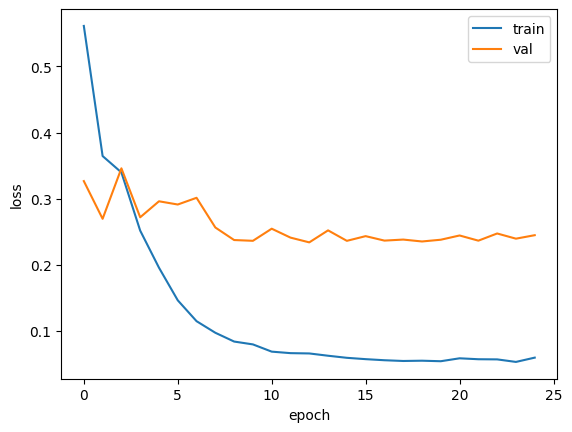

In [25]:
plot_losses(train_losses, val_losses)

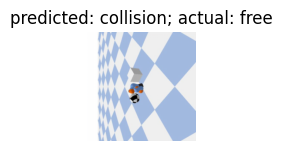

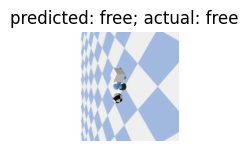

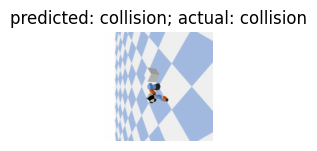

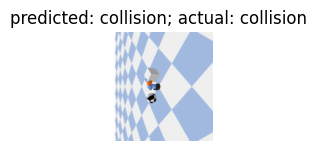

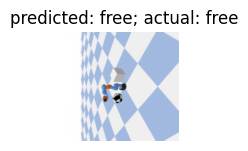

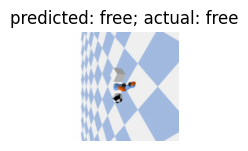

In [24]:
visualize_model(model, dataloaders)

In [19]:
#Increase learning rate
learning_rate = 0.01
num_epochs = 25

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/24
----------


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


train Loss: 0.4340 Acc: 0.7989


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.6396 Acc: 0.7600

Epoch 1/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


train Loss: 0.3401 Acc: 0.8444


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.3860 Acc: 0.8000

Epoch 2/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


train Loss: 0.2254 Acc: 0.9200


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


val Loss: 0.9962 Acc: 0.6000

Epoch 3/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.4582 Acc: 0.8122


100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


val Loss: 1.4013 Acc: 0.6500

Epoch 4/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.4916 Acc: 0.7833


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


val Loss: 0.4557 Acc: 0.7600

Epoch 5/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.3239 Acc: 0.8489


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.9552 Acc: 0.2400

Epoch 6/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.2459 Acc: 0.8967


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


val Loss: 0.4599 Acc: 0.7700

Epoch 7/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.2221 Acc: 0.8856


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.5466 Acc: 0.7900

Epoch 8/24
----------


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


train Loss: 0.1725 Acc: 0.9278


100%|██████████| 2/2 [00:00<00:00,  2.13it/s]


val Loss: 0.3641 Acc: 0.8200

Epoch 9/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


train Loss: 0.1593 Acc: 0.9333


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


val Loss: 0.2894 Acc: 0.8800

Epoch 10/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


train Loss: 0.1501 Acc: 0.9344


100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


val Loss: 0.3373 Acc: 0.8400

Epoch 11/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.1296 Acc: 0.9500


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


val Loss: 0.3143 Acc: 0.8500

Epoch 12/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.1340 Acc: 0.9422


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


val Loss: 0.2797 Acc: 0.8900

Epoch 13/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.1140 Acc: 0.9544


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


val Loss: 0.3062 Acc: 0.8500

Epoch 14/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.1037 Acc: 0.9611


100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


val Loss: 0.2739 Acc: 0.9000

Epoch 15/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


train Loss: 0.0997 Acc: 0.9578


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.2688 Acc: 0.9100

Epoch 16/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


train Loss: 0.1000 Acc: 0.9622


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.2669 Acc: 0.9100

Epoch 17/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0977 Acc: 0.9633


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


val Loss: 0.2633 Acc: 0.9100

Epoch 18/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0889 Acc: 0.9656


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2634 Acc: 0.9100

Epoch 19/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


train Loss: 0.0952 Acc: 0.9644


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


val Loss: 0.2593 Acc: 0.9200

Epoch 20/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


train Loss: 0.0915 Acc: 0.9644


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


val Loss: 0.2586 Acc: 0.9100

Epoch 21/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train Loss: 0.0938 Acc: 0.9711


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.2569 Acc: 0.9100

Epoch 22/24
----------


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


train Loss: 0.0881 Acc: 0.9711


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.2612 Acc: 0.8900

Epoch 23/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0994 Acc: 0.9656


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2589 Acc: 0.9100

Epoch 24/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.0919 Acc: 0.9678


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

val Loss: 0.2606 Acc: 0.9000

Training complete in 4m 41s
Best val Acc: 0.920000


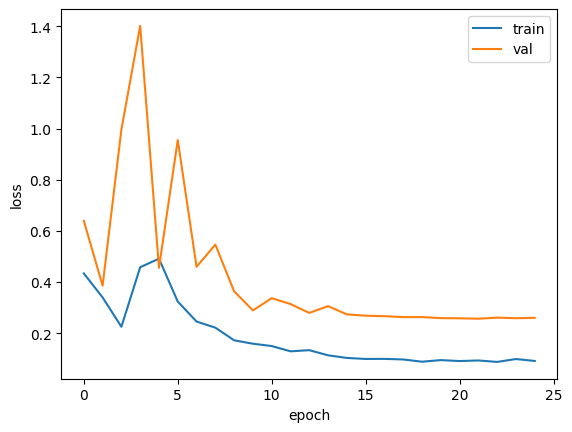

In [22]:
plot_losses(train_losses, val_losses)

The accuracy is 92% for the model with a higher learning rate of 0.01.

In [26]:
#Lower learning rate
learning_rate = 0.0005
num_epochs = 25

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/24
----------


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]


train Loss: 0.0380 Acc: 0.9833


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val Loss: 0.2375 Acc: 0.9000

Epoch 1/24
----------


100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


train Loss: 0.0362 Acc: 0.9889


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val Loss: 0.2320 Acc: 0.9100

Epoch 2/24
----------


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


train Loss: 0.0345 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.2582 Acc: 0.9200

Epoch 3/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0630 Acc: 0.9789


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.2668 Acc: 0.8900

Epoch 4/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0495 Acc: 0.9811


100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


val Loss: 0.2386 Acc: 0.9100

Epoch 5/24
----------


100%|██████████| 15/15 [00:12<00:00,  1.15it/s]


train Loss: 0.0376 Acc: 0.9867


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.3439 Acc: 0.8600

Epoch 6/24
----------


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


train Loss: 0.0554 Acc: 0.9767


100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


val Loss: 0.2562 Acc: 0.9100

Epoch 7/24
----------


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


train Loss: 0.0398 Acc: 0.9844


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


val Loss: 0.2487 Acc: 0.9000

Epoch 8/24
----------


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


train Loss: 0.0391 Acc: 0.9867


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2448 Acc: 0.9100

Epoch 9/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


train Loss: 0.0335 Acc: 0.9933


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.2505 Acc: 0.9100

Epoch 10/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


train Loss: 0.0307 Acc: 0.9911


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.2448 Acc: 0.9100

Epoch 11/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


train Loss: 0.0310 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.2438 Acc: 0.9100

Epoch 12/24
----------


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


train Loss: 0.0307 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2581 Acc: 0.9000

Epoch 13/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.0279 Acc: 0.9911


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


val Loss: 0.2423 Acc: 0.9100

Epoch 14/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


train Loss: 0.0238 Acc: 0.9956


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


val Loss: 0.2421 Acc: 0.9000

Epoch 15/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0313 Acc: 0.9900


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.2536 Acc: 0.9000

Epoch 16/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.0232 Acc: 0.9967


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


val Loss: 0.2435 Acc: 0.9000

Epoch 17/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0282 Acc: 0.9933


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.2420 Acc: 0.9000

Epoch 18/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.0280 Acc: 0.9911


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


val Loss: 0.2398 Acc: 0.9000

Epoch 19/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


train Loss: 0.0322 Acc: 0.9911


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


val Loss: 0.2426 Acc: 0.9000

Epoch 20/24
----------


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


train Loss: 0.0279 Acc: 0.9967


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


val Loss: 0.2491 Acc: 0.9100

Epoch 21/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0264 Acc: 0.9956


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.2483 Acc: 0.9100

Epoch 22/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


train Loss: 0.0282 Acc: 0.9911


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2452 Acc: 0.9100

Epoch 23/24
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0268 Acc: 0.9933


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2467 Acc: 0.9100

Epoch 24/24
----------


 80%|████████  | 12/15 [00:08<00:02,  1.40it/s]

The accuracy is 91% for the model with a lower learning rate of 0.0005

In [23]:
#Lower no. of epochs
learning_rate = 0.001
num_epochs = 15

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/14
----------


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


train Loss: 0.0901 Acc: 0.9656


100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


val Loss: 0.2519 Acc: 0.8900

Epoch 1/14
----------


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


train Loss: 0.0893 Acc: 0.9656


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


val Loss: 0.2452 Acc: 0.8900

Epoch 2/14
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0808 Acc: 0.9678


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.2493 Acc: 0.8900

Epoch 3/14
----------


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


train Loss: 0.0690 Acc: 0.9756


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


val Loss: 0.2823 Acc: 0.8900

Epoch 4/14
----------


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


train Loss: 0.0596 Acc: 0.9800


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


val Loss: 0.2824 Acc: 0.8700

Epoch 5/14
----------


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


train Loss: 0.0614 Acc: 0.9789


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


val Loss: 0.2392 Acc: 0.8900

Epoch 6/14
----------


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


train Loss: 0.0419 Acc: 0.9856


100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


val Loss: 0.2314 Acc: 0.9100

Epoch 7/14
----------


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


train Loss: 0.0376 Acc: 0.9867


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


val Loss: 0.2305 Acc: 0.9100

Epoch 8/14
----------


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


train Loss: 0.0329 Acc: 0.9922


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


val Loss: 0.2388 Acc: 0.9200

Epoch 9/14
----------


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


train Loss: 0.0415 Acc: 0.9867


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


val Loss: 0.2445 Acc: 0.9100

Epoch 10/14
----------


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train Loss: 0.0315 Acc: 0.9900


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.2436 Acc: 0.9100

Epoch 11/14
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0351 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.2391 Acc: 0.9000

Epoch 12/14
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0291 Acc: 0.9911


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.2412 Acc: 0.9000

Epoch 13/14
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0384 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


val Loss: 0.2360 Acc: 0.9200

Epoch 14/14
----------


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


train Loss: 0.0363 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

val Loss: 0.2444 Acc: 0.9100

Training complete in 2m 54s
Best val Acc: 0.920000


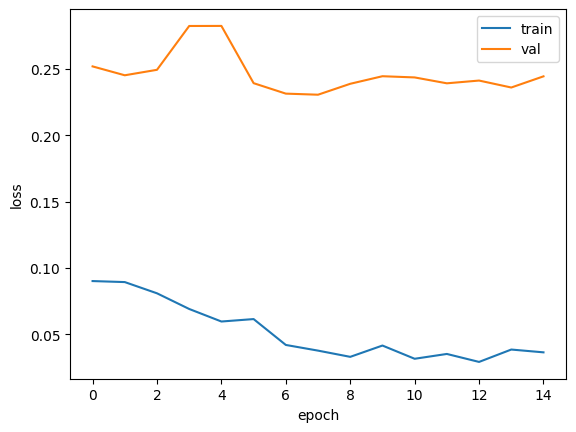

In [25]:
plot_losses(train_losses, val_losses)

The accuracy is 92% for the model that runs with 15 epochs.

In [28]:
#Higher no. of epochs
learning_rate = 0.001
num_epochs = 30

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [29]:
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs, device=device)

Epoch 0/29
----------


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


train Loss: 0.0256 Acc: 0.9956


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


val Loss: 0.2414 Acc: 0.9100

Epoch 1/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


train Loss: 0.0388 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.2662 Acc: 0.9100

Epoch 2/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


train Loss: 0.0248 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


val Loss: 0.2890 Acc: 0.9000

Epoch 3/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0700 Acc: 0.9744


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


val Loss: 0.3396 Acc: 0.9100

Epoch 4/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0452 Acc: 0.9856


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


val Loss: 0.3177 Acc: 0.8700

Epoch 5/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


train Loss: 0.0337 Acc: 0.9889


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2350 Acc: 0.9000

Epoch 6/29
----------


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


train Loss: 0.0631 Acc: 0.9811


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.2093 Acc: 0.9300

Epoch 7/29
----------


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train Loss: 0.0360 Acc: 0.9922


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


val Loss: 0.1997 Acc: 0.9200

Epoch 8/29
----------


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


train Loss: 0.0358 Acc: 0.9933


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


val Loss: 0.1930 Acc: 0.9400

Epoch 9/29
----------


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


train Loss: 0.0346 Acc: 0.9933


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.1964 Acc: 0.9200

Epoch 10/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


train Loss: 0.0285 Acc: 0.9967


100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


val Loss: 0.1978 Acc: 0.9400

Epoch 11/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0297 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.2077 Acc: 0.9400

Epoch 12/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0253 Acc: 0.9967


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


val Loss: 0.1989 Acc: 0.9300

Epoch 13/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0255 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.2008 Acc: 0.9300

Epoch 14/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0242 Acc: 0.9944


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


val Loss: 0.1973 Acc: 0.9300

Epoch 15/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0254 Acc: 0.9900


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


val Loss: 0.1972 Acc: 0.9300

Epoch 16/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0205 Acc: 0.9944


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.1978 Acc: 0.9300

Epoch 17/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0224 Acc: 0.9956


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


val Loss: 0.1967 Acc: 0.9300

Epoch 18/29
----------


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train Loss: 0.0198 Acc: 0.9967


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


val Loss: 0.1993 Acc: 0.9300

Epoch 19/29
----------


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


train Loss: 0.0213 Acc: 0.9967


100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


val Loss: 0.1999 Acc: 0.9300

Epoch 20/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


train Loss: 0.0176 Acc: 0.9989


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


val Loss: 0.1993 Acc: 0.9300

Epoch 21/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0203 Acc: 0.9944


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


val Loss: 0.2026 Acc: 0.9400

Epoch 22/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0213 Acc: 0.9956


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


val Loss: 0.2019 Acc: 0.9400

Epoch 23/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0234 Acc: 0.9956


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.2020 Acc: 0.9400

Epoch 24/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0196 Acc: 0.9967


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


val Loss: 0.1994 Acc: 0.9300

Epoch 25/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0217 Acc: 0.9967


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


val Loss: 0.2041 Acc: 0.9400

Epoch 26/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


train Loss: 0.0218 Acc: 0.9922


100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


val Loss: 0.2007 Acc: 0.9400

Epoch 27/29
----------


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


train Loss: 0.0249 Acc: 0.9956


100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


val Loss: 0.1973 Acc: 0.9300

Epoch 28/29
----------


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


train Loss: 0.0261 Acc: 0.9944


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


val Loss: 0.2014 Acc: 0.9300

Epoch 29/29
----------


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


train Loss: 0.0216 Acc: 0.9956


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

val Loss: 0.2001 Acc: 0.9300

Training complete in 5m 35s
Best val Acc: 0.940000


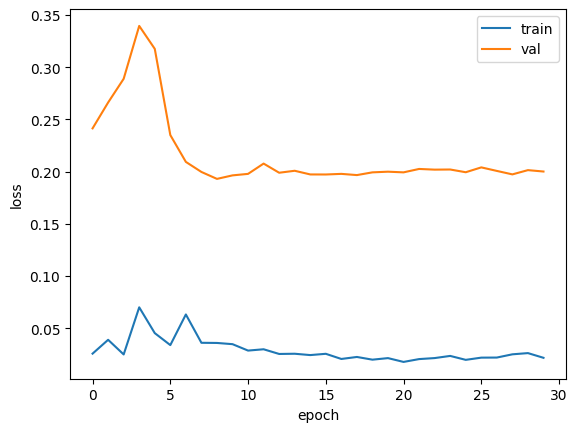

In [30]:
plot_losses(train_losses, val_losses)

The accuracy is 94% for the model that runs with 30 epochs.